DID Effect: 0.018142168015557472


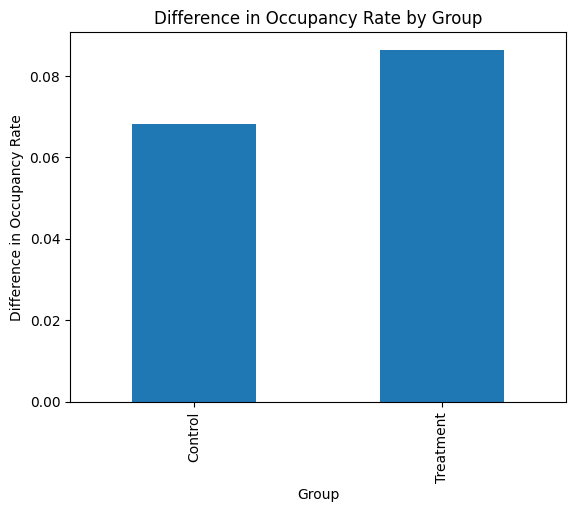

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
 
# Load the data
data = pd.read_csv('host_level_aggregated_chicago_data.csv')
 
# Step 1: Filter for rows only for period 18 and 19
filtered_data = data[data['superhost_period_all'].isin([19, 20])]
 
# Step 2: Remove all hosts who do not have data for both periods
hosts_with_both_periods = filtered_data.groupby('Airbnb Host ID')['superhost_period_all'].nunique()
valid_hosts = hosts_with_both_periods[hosts_with_both_periods == 2].index
filtered_data = filtered_data[filtered_data['Airbnb Host ID'].isin(valid_hosts)]
 
# Step 3: Create control group (hosts not a superhost in period 18 and also not in period 19)
control_group = filtered_data.groupby('Airbnb Host ID').filter(
    lambda x: (x['Superhost'].iloc[0] == 0) and (x['Superhost'].iloc[1] == 0)
)
 
# Step 4: Create treatment group (hosts not a superhost in period 18 but became a superhost in period 19)
treatment_group = filtered_data.groupby('Airbnb Host ID').filter(
    lambda x: (x['Superhost'].iloc[0] == 0) and (x['Superhost'].iloc[1] == 1)
)
 
# Step 5: Prepare data for DID analysis
control_group['Group'] = 'Control'
treatment_group['Group'] = 'Treatment'
combined_data = pd.concat([control_group, treatment_group])
 
# Step 6: Calculate the difference in occupancy rate between the two periods
combined_data['Period'] = combined_data['superhost_period_all'].apply(lambda x: 'Pre' if x == 19 else 'Post')
grouped = combined_data.groupby(['Airbnb Host ID', 'Group', 'Period'])['occupancy_rate'].mean().unstack()
 
# Calculate the difference for each group
grouped['Difference'] = grouped['Post'] - grouped['Pre']
did_data = grouped.reset_index()
 
# Calculate DID
did_summary = did_data.groupby('Group')['Difference'].mean()
did_effect = did_summary['Treatment'] - did_summary['Control']
 
print(f"DID Effect: {did_effect}")
 
# Plotting results
did_data.groupby('Group')['Difference'].mean().plot(kind='bar')
plt.title('Difference in Occupancy Rate by Group')
plt.ylabel('Difference in Occupancy Rate')
plt.xlabel('Group')
plt.show()